<a href="https://colab.research.google.com/github/google/applied-machine-learning-intensive/blob/master/content/05_deep_learning/02_natural_language_processing/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Natural Language Processing

Look almost anywhere around you, and you'll see an application of natural language processing (NLP) at work. This broad field covers everything from spellcheck to translation between languages to full machine understanding of human language.

In this lesson we'll work through the typical process of an NLP problem. We'll first use a bag-of-words approach to train a simple classifier model. Then we'll use a sequential approach (considering the order of words) to train an RNN model.

## Exploratory Data Analysis

We will use the [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) from the UCI Machine Learning Repository. This dataset was used in the paper 'From Group to Individual Labels using Deep Features,' Kotzias et. al., KDD 2015 and contains 3000 user reviews from IMDB, Amazon, and Yelp with the corresponding sentiment of each review (positive: 1 or negative: 0). This supervised problem of predicting sentiment is often called a "sentiment analysis task."

### Download the Data

In order to get reproducible results for this lab, we'll first seed the random number generators.

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

Next we'll download and unzip the data.

In [1]:
import zipfile
import io
import shutil
import os
import urllib.request

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip'

# Download zip file from url.
zipdata = io.BytesIO()
zipdata.write(urllib.request.urlopen(url).read())

# Extract zip files.
zfile = zipfile.ZipFile(zipdata)
zfile.extractall()
zfile.close()

# Rename directory to "data".
shutil.rmtree('./data', ignore_errors=True)
shutil.move('sentiment labelled sentences', 'data')

os.listdir('data')

['.DS_Store',
 'amazon_cells_labelled.txt',
 'readme.txt',
 'yelp_labelled.txt',
 'imdb_labelled.txt']

There are three files that we'll use in our model: `amazon_cells_labelled.txt`, `imdb_labelled.txt`, and `yelp_labelled.txt`. As you can tell from the `_labelled` portion of the names, this will be a supervised learning problem.

### Load the Data

The downloaded data is split across three files: `amazon_cells_labelled.txt`, `imdb_labelled.txt`, and `yelp_labelled.txt`. Each file has two tab-separated columns, one containing the review text and one containing the sentiment label. Let's combine all the files into one DataFrame, and then get a sense of what the data looks like.

In [3]:
import pandas as pd

df = pd.DataFrame(columns=['review', 'label'])

for file in sorted(os.listdir('data')):
  if file.endswith('_labelled.txt'):
    df = df.append(pd.read_csv(os.path.join('data', file), 
                               sep='\t',
                               names=['review', 'label']))

df.describe()

/var/folders/40/28srkw8j0d53sp2bwbx3h8h00000gn/T/ipykernel_90607/3556073262.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join('data', file),
/var/folders/40/28srkw8j0d53sp2bwbx3h8h00000gn/T/ipykernel_90607/3556073262.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join('data', file),
/var/folders/40/28srkw8j0d53sp2bwbx3h8h00000gn/T/ipykernel_90607/3556073262.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join('data', file),


,review,label
count,2748,2748
unique,2731,2
top,If you like a loud buzzing to override all you...,1
freq,2,1386


Interesting. We were expecting `3000` data points, but only got `2748`. What's going on?

It turns out that the IMDB data contains some rows with single double quotes. By default, when the parser sees double quotes, it stops performing a search for another tab until it finds a closing double quote. Since this quote is alone on the line, it causes the parser to "eat" quite a few lines of the data file, as illustrated by the code block below.

In [4]:
df.iloc[1019]['review']

' The structure of this film is easily the most tightly constructed in the history of cinema.  \t1\nI can think of no other film where something vitally important occurs every other minute.  \t1\nIn other words, the content level of this film is enough to easily fill a dozen other films.  \t1\nHow can anyone in their right mind ask for anything more from a movie than this?  \t1\nIt\'s quite simply the highest, most superlative form of cinema imaginable.  \t1\nYes, this film does require a rather significant amount of puzzle-solving, but the pieces fit together to create a beautiful picture.  \t1\nThis short film certainly pulls no punches.  \t0\nGraphics is far from the best part of the game.  \t0\nThis is the number one best TH game in the series.  \t1\nIt deserves strong love.  \t1\nIt is an insane game.  \t1\nThere are massive levels, massive unlockable characters... it\'s just a massive game.  \t1\nWaste your money on this game.  \t1\nThis is the kind of money that is wasted proper

In order to get around this, we need to tell the parser to turn off quote detection using the `quoting` argument. The possible values are:

Value | Meaning
------|----------
0     | QUOTE_MINIMAL (default)
1     | QUOTE_ALL
2     | QUOTE_NONNUMERIC
3     | QUOTE_NONE


In [5]:
import pandas as pd

df = pd.DataFrame(columns=['review', 'label'])

for file in sorted(os.listdir('data')):
  if file.endswith('_labelled.txt'):
    df = df.append(pd.read_csv(os.path.join('data', file), 
                               sep='\t',
                               names=['review', 'label'],
                               quoting=3))

df.describe()

/var/folders/40/28srkw8j0d53sp2bwbx3h8h00000gn/T/ipykernel_90607/890021767.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join('data', file),
/var/folders/40/28srkw8j0d53sp2bwbx3h8h00000gn/T/ipykernel_90607/890021767.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join('data', file),
/var/folders/40/28srkw8j0d53sp2bwbx3h8h00000gn/T/ipykernel_90607/890021767.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(os.path.join('data', file),


,review,label
count,3000,3000
unique,2983,2
top,Great phone.,0
freq,2,1500


That looks much better. We got lucky that none of the reviews had embedded tabs, or they would have been quoted and our simple fix would not have worked.

Notice that the `read_csv()` call didn't return an error when it encountered an unbalanced quote on a line. It happily loaded the file thinking that the quote was intentional and meant to make the data span multiple lines. *Always verify that the data you loaded looks like you expected it to!*

Now let's look at a few of the reviews. The [documentation](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) says that positive reviews are labelled with a `1` and negative with a `0`. Let's sample a few and see if we agree.

First the bad,

In [6]:
df[df['label'] == 0].sample(10)

,review,label
257,I as well would've given godfathers zero stars...,0
831,Very poor service.,0
855,Just does not work.,0
842,Terrible.. My car will not accept this cassette.,0
916,While I managed to bend the leaf spring back i...,0
647,The least said about the acting the better.,0
143,And the red curry had so much bamboo shoots an...,0
454,"I wasn't expecting Oscar material, but this?",0
616,My friend did not like his Bloody Mary.,0
544,"sucked, most of the stuff does not work with m...",0


And then the good.

In [7]:
df[df['label'] == 1].sample(10)

,review,label
945,It is easy to turn on and off when you are in ...,1
491,"This movie creates its own universe, and is fa...",1
63,We'd definitely go back here again.,1
550,"I really do recommend this place, you can go w...",1
376,This was such an awesome movie that i bought i...,1
432,Service is quick and friendly.,1
808,When a song could explain the emotions of the ...,1
102,Definitely a bargain.,1
77,If you want a movie that's not gross but gives...,1
418,First time going but I think I will quickly be...,1


The sentiment seems to check out. This concludes the EDA that we'll do for this dataset. Let's move on to data preparation for the model.

## Train/Test Split

We'll create two different models in this lab. Common to both is the need to split the dataset so that 80% is used for training and the other 20% is used for testing.


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  df['review'], df['label'].astype('int'),
  test_size=0.2, random_state=1000)

print(len(X_train), len(X_test), len(y_train), len(y_test))

2400 600 2400 600


The labels are simple `0` and `1` values, so we don't need to do any preprocessing there. The reviews themselves are variable length text strings. Each model will handle them slightly differently, so we'll save the model-specific preprocessing for when we encounter each model.

## Bag-of-Words Model

We will first use a bag-of-words (BOW) approach to vectorize the sentences. This means we will consider each review as a "bag of words," where the order of the words does not matter. Using this bag we'll try to assign sentiment to the review.

In order to create the bags, we'll use scikit-learn's [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class. The class converts a corpus of text into a sparse matrix that represents the counts of the number of times each word appears in the text.

Before applying this to our dataset, let's make sure we understand what's going on. Say we have a couple of sentences that we want to vectorize. One about [bullied buffalo in Buffalo, NY](https://en.wikipedia.org/wiki/Buffalo_buffalo_Buffalo_buffalo_buffalo_buffalo_Buffalo_buffalo) and the other about their peers in Seattle, WA. We can count-vectorize the data, as shown in the code block below.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

data = [
  "Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo",
  "Seattle buffalo Seattle buffalo buffalo buffalo Seattle buffalo",
]

vectorizer = CountVectorizer()
vectorizer.fit(data)

data_vec = vectorizer.transform(data)

print(data_vec)

  (0, 0)	8
  (1, 0)	5
  (1, 1)	3


The resultant matrix is:

Sentence | buffalo | seattle
--|---------|--------
"Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo" |    8    |    0
"Seattle buffalo Seattle buffalo buffalo buffalo Seattle buffalo" |    5    |    3

As you can see, the first sentence has eight instances of the word *buffalo* and no instances of *seattle*, while the second sentence has five *buffalo* and three *seattle*. Case does not matter, nor does context (used as a noun, verb, etc.). Only the letters count.

The representation is a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix). In these two sentences consisting of two words, that seems a little strange. But if you think about the fact that there are currently almost `200,000` English words in use while the average sentence is less than `20` words, you can see why sparse matrices make sense here.


And what happens if the data we're transforming contains words we didn't fit the vectorizer to?

In [11]:
data = ['Buffalo Buffalo wings']

data_vec = vectorizer.transform(data)

print(data_vec)

  (0, 0)	2


Unknown words, such as 'wings' in this case, just don't appear in the matrix.

Let's count-vectorize our training data and see how many words are in our vocabulary.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

len(vectorizer.vocabulary_)

4523

We can now transform our training data into a count vector and train a model. For a basic model, we'll use a logistic regression.

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
X_train_vec = vectorizer.transform(X_train)
model.fit(X_train_vec, y_train)

print('Training accuracy: {}'.format(model.score(X_train_vec, y_train)))

Training accuracy: 0.97625


That is excellent training accuracy. Let's see how well it generalizes.

In [14]:
X_test_vec = vectorizer.transform(X_test)
print('Testing accuracy: {}'.format(model.score(X_test_vec, y_test)))

Testing accuracy: 0.8633333333333333


It seems like our model might have overfit a bit. With over `97%` training accuracy and only `86%` testing accuracy, we likely need to work on making our model generalize better.

### Grammar

So far we have only used a bag of words on raw words to train our model. That's fine in some cases since words are often grammatically in the same class. But what about when they are not? In our "Buffalo buffalo..." example, the same word was used to represent a mix of nouns, verbs, and other parts of speech. What if the number of adjectives or nouns or some other part of speech affected the sentiment of the review that we are classifying?

We can test this by using a toolkit that classifies words in sentences, and then we feed those classifications into our model. In this section we'll use [spaCY](https://spacy.io/) to add metadata to our reviews and then pass the reviews and metadata through our model.

[spaCy](https://spacy.io) is a library for advanced NLP tools. It's built based on state-of-the-art research and designed to be efficient for industry use. spaCy is extremely useful for extracting more complex linguistic features from text. Another mature and popular Python NLP toolkit is [NLTK](https://www.nltk.org/), which is a bit more academic-oriented.

We must specify a linguistic model for spaCy to use. For this exercise we'll use their "medium-sized" English language model. If you already have this model downloaded, you can skip to the `load` step below.

**Note:** This is a large file, so it may take a few minutes to download and process.

In [17]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 17.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


After the model is downloaded, we can import it directly using a Python `import` statement. After the import we can load the model.

In [18]:
import en_core_web_md

spacy_model = en_core_web_md.load()

And now we can use spaCY to annotate our data. Let's look at one of our reviews:

In [19]:
X_train.iloc[0]

'Reversible plug works great.'

We can then call spaCY directly and get information such as the part of speech of each word in our review.

spaCy language models process raw text into a `Doc` object, which is a collection of `Token` objects. Each `Token` contains many useful [linguistic annotations](https://spacy.io/usage/linguistic-features). For example, `.text` stores the raw text of a `Token` and `.pos_` stores its Part of Speech (pos) tag.



In [20]:
tokens = spacy_model(X_train.iloc[0])
for token in tokens:
  print(token.text, token.pos_)

Reversible ADJ
plug NOUN
works VERB
great ADJ
. PUNCT


Many of the annotations are obvious, such as **NOUN**, but others are less so. The [spaCY annotation documentation](https://spacy.io/api/annotation) is a good place to look if you are unsure about an annotation.

So how do we actually add annotations to our reviews?

Since we are using "bag of words" annotations at this point, we have a bit of flexibility. We could just add the spaCY output at the end of the sentence:

```
  the big dog jumps DET ADJ NOUN VERB
```

or we could add it after each word:

```
  the DET big ADJ dog NOUN jumps VERB
```

Functionally these are the same in "bag of words" models. Order and case don't matter. If the absolute number of adjectives matter or some other factor like that, then this type of feature engineering could be useful.

What if it matters to us "how" a word was used, not just "that" a word was used? In this case we need to combine the grammar with the word.

Let's create a function to do that.

In [21]:
def add_pos_tags(reviews_raw):
  reviews = []
  for i, review in enumerate(reviews_raw):
    tokens = spacy_model(review)
    review_with_pos = []
    for token in tokens:
      review_with_pos.append(token.text+"_"+token.pos_)
    reviews.append(' '.join(review_with_pos))
  return reviews

print(add_pos_tags("the big dog"))

['t_X', 'h_X', 'e_X', ' _SPACE', 'b_X', 'i_PRON', 'g_INTJ', ' _SPACE', 'd_X', 'o_INTJ', 'g_INTJ']


Let's now apply this to our entire dataset.

In [22]:
X_train_annotated = add_pos_tags(X_train)
X_test_annotated = add_pos_tags(X_test)

vectorizer = CountVectorizer()
vectorizer.fit(X_train_annotated)

X_train_vec = vectorizer.transform(X_train_annotated)
X_test_vec = vectorizer.transform(X_test_annotated)

print(X_train_annotated[0])

Reversible_ADJ plug_NOUN works_VERB great_ADJ ._PUNCT


In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(X_train_vec, y_train)

print('Training accuracy: {}'.format(model.score(X_train_vec, y_train)))
print('Testing accuracy: {}'.format(model.score(X_test_vec, y_test)))

Training accuracy: 0.9816666666666667
Testing accuracy: 0.8566666666666667


Our training accuracy really went up, but our testing accuracy went down. We are overfitting even more now.

This isn't much of a surprise, but is interesting to see that adding even more context (features) can allow a model to fit even tighter than can be done with raw data.

## Sequential Model

Much of the meaning of language depends on the order of words: "That movie was not really good" is not quite the same as "That movie was really not good." For more complicated NLP tasks, a bag-of-words approach does not capture enough useful information. In this section we will instead work with a Recurrent Neural Network (RNN) model, which is specifically designed to capture information about the order of sequences. 

### Preprocessing

We can't use `CountVectorizer` here, so we will need to do some slightly different preprocessing. We can first use the `keras` `Tokenizer` to learn a vocabulary, and then transform each review into a list of indices. Note that we will not include part-of-speech information for this model.

In [24]:
from tensorflow import keras

tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

print(X_train.iloc[0])
print(X_train_tokenized[0])

Reversible plug works great.
[1937, 364, 99, 21]


We need to pad our input so all vectors have the same length. A quick histogram of review lengths shows that almost all reviews have fewer than 100 words. Let's take a closer look at the distribution of lengths.

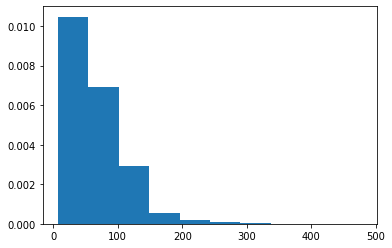

In [25]:
import matplotlib.pyplot as plt

review_lengths = [len(review) for review in X_train]
plt.hist(review_lengths, density=True)
plt.show()

Almost all reviews have fewer than 50 words! Therefore, we will pad to a maximum review length of 50.

In [26]:
maxlen = 50

X_train_padded = keras.preprocessing.sequence.pad_sequences(
    X_train_tokenized, padding='post', maxlen=maxlen)
X_test_padded = keras.preprocessing.sequence.pad_sequences(
    X_test_tokenized, padding='post', maxlen=maxlen)

print(X_train_padded[0])

[1937  364   99   21    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Pre-Trained Word Embeddings

Word embeddings are foundational to most NLP tasks. It's common to experiment with embeddings, feature extraction, or a combination of both to determine what works best with your specific data and problem.

In practice, instead of training our own embeddings, we can often take advantage of existing embeddings that have already been trained. This is especially useful when we have a small dataset and want or need the richer meaning that comes from embeddings trained on a larger dataset. 

There are a variety of extensively pre-trained word embeddings. One of the most powerful and widely-used is [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/). Luckily for us, the spaCy model we downloaded is already integrated with 300-dimensional GloVe embeddings. 

All we need to do is load these embeddings into an `embedding_matrix` so that each word index properly matches with the words in our dataset. We can access the `tokenizer`'s vocabulary using `.word_index`.

*Note: This may take a few minutes to run.*


In [29]:
%%time
# Include an extra index for the "<PAD>" token.
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
  token = spacy_model(word)[0]
  # Make sure spaCy has an embedding for this token.
  if not token.is_oov:
    embedding_matrix[i] = token.vector

print(embedding_matrix.shape)

(4620, 300)
CPU times: user 16.7 s, sys: 48.7 ms, total: 16.7 s
Wall time: 16.8 s


Loading the embeddings may take a little while to run. When it's done we'll have an `embedding_matrix` where each word index corresponds to a 300-dimensional GloVe vector. We can load this into an `Embedding` layer to train a model or visualize the embeddings.

Also note that we have slightly more tokens now than from using `CountVectorizer`. This means that Keras' `Tokenizer` splits sentences into tokens using slightly different rules.

### RNN Model

This model will have three layers:

1. `Embedding`

   We initialize its weights using the `embedding_matrix` of pre-trained GloVe embeddings. We set `trainable=False` to prevent the weights from being updated during training. You can keep `trainable=True` to allow for additional training, or "fine-tuning", of these weights. We also set `mask_zero=True` to ensure we do not train parameters based on the `"<PAD>"` tokens.

2. `LSTM` (Long Short-Term Memory)

   This is a type of RNN architecture that is especially good at handling long sequences of information. This layer takes input of dimensions `(batch size, maxlen, embedding dimension)` and returns output of dimensions `(batch size, 64)`. A larger output size means a more complex model; we have chosen 64 after tuning based on model performance.

3. `Dense`

   A final layer to return a prediction of either positive or negative sentiment.

In [28]:
%%time
model = keras.Sequential([
  keras.layers.Embedding(
    vocab_size,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True
  ),
  keras.layers.LSTM(64),
  keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


2022-07-03 00:25:12.659454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         1386000   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,479,505
Trainable params: 93,505
Non-trainable params: 1,386,000
_________________________________________________________________
CPU times: user 782 ms, sys: 30.4 ms, total: 813 ms
Wall time: 787 ms


We will train this model for 10 epochs since it is slower to train per epoch and reaches high training accuracy after 10 epochs. We use a batch size of 64 based on hyperparameter tuning.

In [31]:
%%time
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

history = model.fit(
    X_train_padded,
    y_train,
    epochs=10,
    batch_size=64
)

Epoch 1/10
38/38 [==============================] - 4s 31ms/step - loss: 0.6323 - accuracy: 0.6521
Epoch 2/10
38/38 [==============================] - 1s 35ms/step - loss: 0.5719 - accuracy: 0.6992
Epoch 3/10
38/38 [==============================] - 2s 44ms/step - loss: 0.5292 - accuracy: 0.7362
Epoch 4/10
38/38 [==============================] - 2s 56ms/step - loss: 0.4899 - accuracy: 0.7633
Epoch 5/10
38/38 [==============================] - 3s 67ms/step - loss: 0.4627 - accuracy: 0.7792
Epoch 6/10
38/38 [==============================] - 2s 64ms/step - loss: 0.4377 - accuracy: 0.7946
Epoch 7/10
38/38 [==============================] - 2s 61ms/step - loss: 0.4152 - accuracy: 0.8108
Epoch 8/10
38/38 [==============================] - 2s 50ms/step - loss: 0.3806 - accuracy: 0.8238
Epoch 9/10
38/38 [==============================] - 2s 61ms/step - loss: 0.3495 - accuracy: 0.8438
Epoch 10/10
38/38 [==============================] - 2s 57ms/step - loss: 0.3189 - accuracy: 0.8654
CPU times

And finally, we can evaluate the accuracy of the model on our test data.

In [32]:
loss, acc = model.evaluate(X_test_padded, y_test)
print('Test accuracy: {}'.format(acc))

19/19 [==============================] - 2s 25ms/step - loss: 0.5938 - accuracy: 0.7017
Test accuracy: 0.7016666531562805


Note that the final testing set accuracy is not significantly higher than that of our Logistic Regression model. We are using a complex model on a small dataset, which is prone to overfitting. You can usually achieve more generalizable results with a larger dataset.

# Exercise 1: A Tale of Two Authors

In this exercise we will create a model that can determine if a paragraph was written by Jane Austen or Charles Dickens. We'll use a [dataset containing the works of the two authors](https://www.kaggle.com/joshmcadams/jane-austen-and-charles-dickens) sourced from [Project Gutenberg](https://www.gutenberg.org/).

Your task is to download the data and build a classifier that can distinguish between the works of the two authors using techniques covered earlier in this lab. Experiment with different types of models, and see if you can build one that trains and generalizes well.

Use as many text and code cells as you need. Be sure to explain your work.

## **Student Solution**

In [0]:
# Your code goes here

---